# Gender Biases in Student Evaluations of Teachers
============================================================================


In [1]:
# boilerplate
%matplotlib inline
import math
import numpy as np
import pandas as pd
from numpy.random import random
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
from __future__ import division

# initialize PRNG
rs = np.random.RandomState(seed=1)

Permutation test code
============
You must install the _permute_ package to use this code. Install instructions can be found at https://github.com/statlab/permute.  Our analysis uses version 0.1.alpha3.

In [2]:
from permute.core import corr  
from permute.stratified import sim_corr
import permute
print "permute: version", permute.__version__

permute: version 0.1.alpha3


## Read data and define new fields

In [3]:
dat = pd.read_stata("../../SET data/permutation_all triplets.dta",  convert_categoricals=False )
dat = dat[dat.admission_cep == 0]
dat.describe()

#dat = pd.read_stata("sample_permutation.dta",  convert_categoricals=False)
#dat.describe()

,student_id,year,entreescpoen,stu_male,stu_female,admission_exam,admission_cep,admission_bactb,admission_other,stu_avg_final,...,history,micro,ip,macro,socio,scpo,both_female,both_male,stumale_proffemale,stufemale_profmale
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2470.055664,2010.388889,2010.277778,0.500000,0.500000,0.833333,0.111111,0.055556,0,13.013119,...,0.222222,0.277778,0.166667,0.055556,0.222222,0.055556,0.222222,0.277778,0.222222,0.277778
std,1242.043377,1.243283,1.319784,0.514496,0.514496,0.383483,0.323381,0.235702,0,1.598777,...,0.427793,0.460889,0.383482,0.235702,0.427793,0.235702,0.427793,0.460889,0.427793,0.460889
min,209.000000,2008.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,9.833334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1634.000000,2010.000000,2009.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0,12.243056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2365.500000,2010.000000,2010.000000,0.500000,0.500000,1.000000,0.000000,0.000000,0,13.270833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3404.500000,2011.000000,2011.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0,14.090278,...,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.750000
max,4414.000000,2012.000000,2012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,15.138889,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
evals = ['q16', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q13', 'q14', 'q15']
if isinstance(dat.q16[0], str):
    for e in evals:
        dat[e].replace(['nonpertinent', 'insuffisant', 'moyen', 'bon', 'excellent'],\
                       [0,1,2,3,4],\
                       inplace=True)
    
dat['course'] = dat['prof_id']
dat.course.loc[dat['history']==1] = 'history' 
dat.course.loc[dat['micro']==1] = 'micro' 
dat.course.loc[dat['ip']==1] = 'ip' 
dat.course.loc[dat['macro']==1] = 'macro' 
dat.course.loc[dat['socio']==1] = 'socio' 
dat.course.loc[dat['scpo']==1] = 'scpo' 

dat['gender'] = dat['prof_male']
dat.gender.loc[dat.gender==1] = 'M'
dat.gender.loc[dat.gender==0] = 'F'
dat['student_gender'] = dat['stu_male']
dat.student_gender.loc[dat.student_gender==1] = 'M'
dat.student_gender.loc[dat.student_gender==0] = 'F'

# Define the fun times for class
dat['plumTime'] = (dat['extremetime'] < 2) & dat['day'].isin([2,3,4])

# Define difference in final and midterm exams
dat['diff_final_cont'] = dat['note_cm'] - dat['note_conf']

# Define the permutation strata: permute independently by course/semester
dat['course_year'] = dat['course'] + dat['year'].map(str)
course_year_values = dat['course_year'].unique()
course_year_values.sort()
dat['course_year_int'] = dat['course_year']
for i in range(len(dat.course_year.unique())):
    dat.course_year_int.loc[dat.course_year == course_year_values[i]] = i
dat.course_year_int = dat.course_year_int.astype(int)

/Users/Kellie/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Data filtering

Most of the analyses omit grades in PI, for two reasons: 
1. The final exam is oral
2. There is a large imbalance in the gender of the instructors: 52 male, 12 female
3. Since the course is "easy," that would bias results in favor of making male instructors look more effective

In [5]:
# remove the Political Institutions courses
datNoIp = dat.copy()
datNoIp = datNoIp[datNoIp['course'] != 'ip']

# Summary statistics

## Instructor level statistics

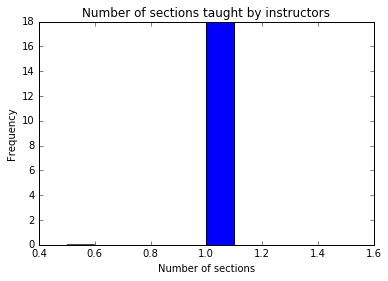

Instructors who taught in more than one course (# courses):
Series([], Name: course, dtype: int64)


In [6]:
# How many sections did instructors teach?
grouped = dat.groupby('prof_id')
plt.hist(np.array(grouped.count().course_year))
plt.title("Number of sections taught by instructors")
plt.xlabel("Number of sections")
plt.ylabel("Frequency")
plt.show()

# Did any instructors teach sections in more than one course?
numcourses = grouped.course.agg(lambda x: len(np.unique(x)))
print "Instructors who taught in more than one course (# courses):\n", numcourses[numcourses > 1]

# Start of the analysis

### Ratings v student performance

In [8]:
# Correlation btw avg evaluation score and final exam grade, by course number. Omit IP courses

print 'Analyzing the correlation btw avg evaluation score and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of courses:', prof_ratings['note_cm'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', 'Two-sided p-value', '# Courses'))
for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format(topic, t/nstrat, pupper, pboth, \
                                                                  prof_ratings['note_cm'].size))

Analyzing the correlation btw avg evaluation score and final exam grade, by course number
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of courses: 15 


Course       Test stat Upper P-value Two-sided p-value # Courses
history           nan         0.00         0.00         4.00
macro             nan         0.00         0.00         1.00
micro             nan         0.00         0.00         5.00
scpo              nan         0.00         0.00         1.00
socio             nan         0.00         0.00         4.00


### Instructor gender v student performance

In [8]:
# Correlation of final exam and gender, by course.  Excludes IP courses.

print 'Correlation btw final exam average and instructor gender, by course' 

theCols = evals + ['prof_male','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))


(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], \
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of courses w/ male profs:', prof_ratings['prof_male'].sum()
print 'Number of courses w/ female profs:', (1-prof_ratings['prof_male']).sum()
print 'Total number of courses:', prof_ratings['prof_male'].size, '\n'



print ('\n{0:12} {1:8} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Male profs', \
                                                             '# Female profs', '# Courses'))
for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f} {5:12.2f} {6:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_male'].sum(), \
                    (1-prof_ratings['prof_male']).sum(),  prof_ratings['prof_male'].size ))

Correlation btw final exam average and instructor gender, by course
Overall:
Test statistic (sum of correlations): -1.26316627242
One-sided (upper) p-value: 0.9672
Two-sided p-value: 0.0666
Number of courses w/ male profs: 625.0
Number of courses w/ female profs: 324.0
Total number of courses: 949 


Course       Test stat Upper P-value Two-sided p-value # Male profs # Female profs # Courses
history         -0.41         0.89         0.22       154.00        70.00       224.00
ip              -0.09         0.61         0.79       182.00        45.00       227.00
macro           -0.29         0.81         0.39       155.00        73.00       228.00
micro           -0.31         0.82         0.36       148.00        78.00       226.00
scpo            -0.10         0.66         0.70        91.00        44.00       135.00
socio           -0.16         0.73         0.55        77.00        59.00       136.00


### Ratings v grade expectations

In [9]:
# Correlation btw avg evaluation score and avg cont assessment grades, by course number. Includes IP
print 'Analyzing the correlation btw avg evaluation score and cont assessment, by course number' 

theCols = evals + ['prof_male','plumTime','note_conf', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Number of courses:', prof_ratings['note_conf'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8}'.format('Course', 'Test stat', 'Upper P-value', '# Courses'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f}'.format( topic, t/nstrat, \
                    pupper, prof_ratings['note_conf'].size ))    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by course number
Overall:
Test statistic (sum of correlations): 4.15995140164
One-sided (upper) p-value: 0.0
Number of courses: 1176 


Course       Test stat Upper P-value # Courses
history          1.61         0.00       224.00
ip              -0.09         0.61       227.00
macro            0.77         0.01       228.00
micro            0.65         0.03       226.00
scpo             0.50         0.03       135.00
socio            0.71         0.00       136.00


### Ratings v instructor gender

In [9]:
# Correlation of avg evaluation score and gender, by course.  Includes IP courses.

print 'Analyzing the correlation btw avg evaluation score and gender, by course' 

theCols = evals + ['prof_male','plumTime', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))


(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections w/ male profs:', prof_ratings['prof_male'].sum()
print 'Number of sections w/ female profs:', (1-prof_ratings['prof_male']).sum()
print 'Total number of courses:', prof_ratings['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8} {5:8} {6:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Male profs', \
                                                             '# Female profs', '# Sections'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f} {5:12.2f} {6:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_male'].sum(), \
                    (1-prof_ratings['prof_male']).sum(),  prof_ratings['prof_male'].size ))

Analyzing the correlation btw avg evaluation score and gender, by course
Overall:
Test statistic (sum of correlations): nan
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of sections w/ male profs: 10.0
Number of sections w/ female profs: 8.0
Total number of courses: 18 


Course       Test stat Upper P-value Two-sided p-value # Male profs # Female profs # Sections
history           nan         0.00         0.00         3.00         1.00         4.00
ip                nan         0.00         0.00         2.00         1.00         3.00
macro             nan         0.00         0.00         1.00         0.00         1.00
micro             nan         0.00         0.00         3.00         2.00         5.00
scpo              nan         0.00         0.00         0.00         1.00         1.00
socio             nan         0.00         0.00         1.00         3.00         4.00


### Ratings and gender concordance

In [11]:
# Gender concordance v overall satisfaction, grouped by course
# This looks at how students rate their profs, by course

dMale_stu = dat[dat['stu_male']==1]
dFemale_stu = dat[dat['stu_female']==1]

theCols = evals + ['prof_male','prof_female','plumTime','note_cm', 'course_year_int']

groupedMale = dMale_stu.groupby(['course_number'])
groupedFemale = dFemale_stu.groupby(['course_number'])
prof_ratings_M = groupedMale[theCols].agg(np.mean)
prof_ratings_F = groupedFemale[theCols].agg(np.mean)

nstrat = len(np.unique(prof_ratings_M['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_M['q16'], y = prof_ratings_M['prof_male'], 
                                          group = prof_ratings_M['course_year_int'], seed = rs)
print 'Male students\n'
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with male students:', prof_ratings_M['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dMale_stu['course']):
    perTopic = dMale_stu[dMale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_male'].size ))

print '\n\nFemale students\n'
nstrat = len(np.unique(prof_ratings_F['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_F['note_cm'], y = prof_ratings_F['prof_female'],\
                                      group = prof_ratings_F['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with female students:', prof_ratings_F['prof_female'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dFemale_stu['course']):
    perTopic = dFemale_stu[dFemale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['prof_female'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_female'].size ))

Male students

Overall:
Test statistic (sum of correlations): 3.94386323901
One-sided (upper) p-value: 0.0
Two-sided p-value: 0.0
Number of sections with male students: 1176 


Course       Test stat Upper P-value Two-sided p-value # Sections
history          0.87         0.01         0.01       224.00
ip               0.59         0.04         0.08       227.00
macro            0.71         0.02         0.03       228.00
micro            0.91         0.00         0.01       226.00
scpo             0.50         0.03         0.05       135.00
socio            0.37         0.08         0.16       136.00


Female students

Overall:
Test statistic (sum of correlations): 0.0548441829629
One-sided (upper) p-value: 0.0321
Two-sided p-value: 0.0635
Number of sections with female students: 1176 


Course       Test stat Upper P-value Two-sided p-value # Sections
history         -0.17         0.70         0.61       224.00
ip              -0.53         0.94         0.12       227.00
macro       

### Student performance and gender concordance

In [12]:
# Gender concordance v final exam scores, grouped by course. Excludes IP

dMale_stu = datNoIp[datNoIp['stu_male']==1]
dFemale_stu = datNoIp[datNoIp['stu_female']==1]

theCols = evals + ['prof_male','prof_female','plumTime','note_cm', 'course_year_int']

groupedMale = dMale_stu.groupby(['course_number'])
groupedFemale = dFemale_stu.groupby(['course_number'])
prof_ratings_M = groupedMale[theCols].agg(np.mean)
prof_ratings_F = groupedFemale[theCols].agg(np.mean)

nstrat = len(np.unique(prof_ratings_M['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_M['note_cm'], y = prof_ratings_M['prof_male'], 
                                          group = prof_ratings_M['course_year_int'], seed = rs)
print 'Male students\n'
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with male students:', prof_ratings_M['prof_male'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
    
for topic in np.unique(dMale_stu['course']):
    perTopic = dMale_stu[dMale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_male'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_male'].size ))
    
    
print '\n\nFemale students \n'
nstrat = len(np.unique(prof_ratings_F['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings_F['note_cm'], y = prof_ratings_F['prof_female'], 
                                          group = prof_ratings_F['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with female students:', prof_ratings_F['prof_female'].size, '\n'

print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))

for topic in np.unique(dFemale_stu['course']):
    perTopic = dFemale_stu[dFemale_stu['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['note_cm'], y = prof_ratings['prof_female'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['prof_female'].size ))

Male students

Overall:
Test statistic (sum of correlations): -0.217043087167
One-sided (upper) p-value: 0.6304
Two-sided p-value: 0.7475
Number of sections with male students: 949 


Course       Test stat Upper P-value Two-sided p-value # Sections
history         -0.75         0.99         0.03       224.00
macro            0.18         0.30         0.59       228.00
micro            0.09         0.40         0.79       226.00
scpo             0.24         0.17         0.35       135.00
socio            0.02         0.48         0.95       136.00


Female students 

Overall:
Test statistic (sum of correlations): 0.0622460011854
One-sided (upper) p-value: 0.0282
Two-sided p-value: 0.0565
Number of sections with female students: 949 


Course       Test stat Upper P-value Two-sided p-value # Sections
history         -0.12         0.64         0.73       224.00
macro            0.56         0.05         0.10       228.00
micro            0.35         0.15         0.30       226.00
scpo 

### Association between evaluation scores and class meeting time

In [13]:
# Correlation of avg evaluation score and desirable time, by course. Includes IP courses
print 'Analyzing the correlation btw avg evaluation score and desirable time, by course' 

theCols = evals + ['prof_male','plumTime', 'course_year_int']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['plumTime'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'Overall:'
print 'Test statistic (sum of correlations):', t/nstrat
print 'One-sided (upper) p-value:', pupper
print 'Two-sided p-value:', pboth
print 'Number of sections with desirable times:', prof_ratings['plumTime'].sum()
print 'Number of sections with undesirable times:', (1-prof_ratings['plumTime']).sum()
print 'Total number of sections:', prof_ratings['plumTime'].size, '\n'


print ('\n{0:12} {1:8} {2:8} {3:8} {4:8}'.format('Course', 'Test stat', 'Upper P-value', \
                                                             'Two-sided p-value', '# Sections'))
for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['plumTime'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print ('{0:8} {1:12.2f} {2:12.2f} {3:12.2f} {4:12.2f}'.format( topic, t/nstrat, \
                    pupper, pboth, prof_ratings['plumTime'].size ))

Analyzing the correlation btw avg evaluation score and desirable time, by course
Overall:
Test statistic (sum of correlations): 0.428636540702
One-sided (upper) p-value: 0.2944
Two-sided p-value: 0.5832
Number of sections with desirable times: 432
Number of sections with undesirable times: 744
Total number of sections: 1176 


Course       Test stat Upper P-value Two-sided p-value # Sections
history          0.07         0.42         0.84       224.00
ip              -0.32         0.83         0.34       227.00
macro            0.12         0.36         0.72       228.00
micro            0.07         0.42         0.85       226.00
scpo            -0.01         0.52         0.98       135.00
socio            0.50         0.03         0.06       136.00


### Reliability, self-declared investment in a course

(array([   54.,   617.,  5277.,  6479.,  3822.,  1275.]),
 array([ 4.        ,  4.83333333,  5.66666667,  6.5       ,  7.33333333,
         8.16666667,  9.        ]),
 <a list of 6 Patch objects>)

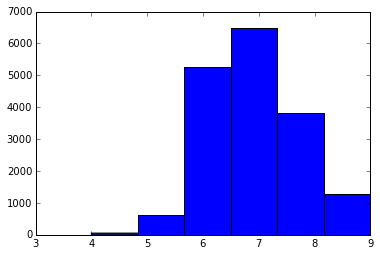

In [14]:
# dat with IP => to test for reliability on q10 (student self-assessed involvment in the course)

wrkld=dat[dat['three_evals']==1]['sum_q10']
plt.hist (wrkld.values, bins=6)

# Other analyses, not in paper

### Instructor gender and student performance, student level

In [15]:
# remove students who took triads from instructors all of the same gender or who have missing final grades.
# Since this uses final exams, remove IP courses

datNonzeroVar = datNoIp.copy()
for g in np.unique(dat['student_id']):
    gg = dat['student_id'] == g
    if (np.var(datNoIp['note_cm'][gg]) == 0.0) or (np.var(datNoIp['prof_male'][gg]) == 0.0) or \
        np.any(np.isnan(datNoIp['note_cm'][gg])):
        datNonzeroVar = datNonzeroVar.drop(datNonzeroVar[datNonzeroVar['student_id'] == g].index)

(t, plower, pupper, pboth, sims) = sim_corr(x = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['prof_male'],\
                                    y = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['note_cm'],\
                                    group = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['student_id'],\
                                    seed = rs)
                                           
print 'Student-level association between instructor gender and performance:', t, plower, pupper, pboth

Student-level association between instructor gender and performance: -56.8312804995 0.0318 0.9682 0.0647


### Association between instructors' average ratings and average continuous assessment grades, by teacher id

In [16]:
# Correlation of avg evaluation score and avg cont assessment grades, by instructor. 
# Includes IP courses

print 'Analyzing the correlation btw avg evaluation score and cont assessment, by instructor' 

theCols = evals + ['prof_male','plumTime','note_conf', 'course_year_int']

grouped = dat.groupby(['prof_id'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'overall', t/nstrat, pupper,\
       prof_ratings['note_conf'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['prof_id'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print topic, t/nstrat, pupper, prof_ratings['note_conf'].size
    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by instructor
overall nan 0.0 372 

history nan 0.0 70
ip nan 0.0 64
macro nan 0.0 92
micro nan 0.0 94
scpo nan 0.0 48
socio nan 0.0 56


C:\Users\albor_000\Anaconda\lib\site-packages\numpy\lib\function_base.py:1890: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


### Association between concordance of student and teacher genders and overall satisfaction

In [17]:
# Correlation of concordance of student and teacher genders and overall satisfaction. Includes IP courses.
print 'Correlation of concordance of student and teacher genders and overall satisfaction'
# Male instructors first

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['q16'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Male instructors:', t/nstrat, pupper

# Female instructors
nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = dFemale['q16'], y = dFemale['stu_female'], 
                                      group = dFemale['course_year_int'], seed=rs)
print 'Female instructors:', t/nstrat, pupper

Correlation of concordance of student and teacher genders and overall satisfaction
Male instructors: 1.93494001309 0.0
Female instructors: 0.107053098135 0.3784


### Dimensions of teaching analyses

In [18]:
# Correlation of avg teaching dimension scores and final exam grade, by course number.
# Excludes IP.
print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'overall', t/nstrat, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'],
                                          group = prof_ratings['course_year_int'], seed = rs)

    print topic, t/nstrat, pupper, prof_ratings['note_cm'].size
    
    

Analyzing the correlation btw teaching dimension scores and final exam grade, by course number
overall 0.0987590542221 0.4292 949 

history 0.266301694947 0.2126 224
macro 0.129425620511 0.3531 228
micro -0.263557677637 0.7824 226
scpo 0.0685267280952 0.3933 135
socio -0.101937311693 0.6507 136


In [19]:
# Correlation of avg teaching dimension scores and final exam grade, by course number.
# Since this uses final, omit IP courses

print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], 
                                          group = prof_ratings['course_year_int'], seed = rs)

print 'overall', t/nstrat, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print topic, t/nstrat, pupper, prof_ratings['note_cm'].size

Analyzing the correlation btw teaching dimension scores and final exam grade, by course number
overall 0.0987590542221 0.4422 949 

history 0.266301694947 0.2146 224
macro 0.129425620511 0.3476 228
micro -0.263557677637 0.7824 226
scpo 0.0685267280952 0.4041 135
socio -0.101937311693 0.6563 136


### Gender concordance analyses

In [20]:
# Gender concordance v continuous assessment grade. Include IP. 
# This looks at how profs are rated by students.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['note_conf'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['note_conf'])]

nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['note_conf'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Concordance of genders v continuous assessment, male instructors:', t/nstrat, pupper

nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dFemale['note_conf'], y=dFemale['stu_female'],
                                          group = dFemale['course_year_int'], seed=rs)
print 'Concordance of genders v continuous assessment, female instructors:', t/nstrat, pupper

Concordance of genders v continuous assessment, male instructors: -0.0138111943318 0.5148
Concordance of genders v continuous assessment, female instructors: 0.845305358553 0.0045


In [21]:
# Gender concordance v preparation & organization. Includes IP courses.
# This looks at how profs are rated by students.

# redundant, but safe:
dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q1'])]  # note! need to re-set in following analyses

dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q1'])]  # note! need to re-set in following analyses

# Male instructors
nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['q1'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Gender concordance v. preparation and organization, male instructors:', t/nstrat, pupper

# Female instructors
nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dFemale['q1'], y=dFemale['stu_female'], 
                                          group = dFemale['course_year_int'], seed=rs)
print 'Gender concordance v. preparation and organization, female instructors:', t/nstrat, pupper

Gender concordance v. preparation and organization, male instructors: 0.936988754656 0.0
Gender concordance v. preparation and organization, female instructors: 0.45206231843 0.0937


In [22]:
# Gender concordance v quality of instructional material. Includes IP courses.
# This looks at how profs are rated by students.

# redundant, but safe:
dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q2'])]  # note! need to re-set in following analyses

dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q2'])]  # note! need to re-set in following analyses

# Male instructors
nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['q2'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Gender concordance v. preparation and organization, male instructors:', t/nstrat, pupper

# Female instructors
nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dFemale['q2'], y=dFemale['stu_female'], 
                                          group = dFemale['course_year_int'], seed=rs)
print 'Gender concordance v. preparation and organization, female instructors:', t/nstrat, pupper

Gender concordance v. preparation and organization, male instructors: 0.66015168178 0.0016
Gender concordance v. preparation and organization, female instructors: 0.781598284818 0.0116


In [23]:
# Gender concordance v quality of animation. Includes IP courses
# This looks at how profs are rated by students.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['q5'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['q5'])]

nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['q5'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Gender concordance v animation, male instructors:', t/nstrat, pupper

nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dFemale['q5'], y=dFemale['stu_female'], 
                                      group = dFemale['course_year_int'], seed=rs)
print 'Gender concordance v animation, female instructors:', t/nstrat, pupper

Gender concordance v animation, male instructors: 1.05749002944 0.0
Gender concordance v animation, female instructors: 0.55120401038 0.0584


### Differences in continuous assessment and final exam grades analyses

In [24]:
# Correlation btw avg evaluation score and difference btw continuous assessment and final grade, by course number
# Exclude IP courses
print 'Avg evaluation score v difference btw continuous assessment & final grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'diff_final_cont', 'course_year_int']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
nstrat = len(np.unique(prof_ratings['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['diff_final_cont'], 
                                          group = prof_ratings['course_year_int'], seed = rs)
print 'overall', t/nstrat, pupper,\
       prof_ratings['diff_final_cont'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    nstrat = len(np.unique(prof_ratings['course_year_int']))
    (t, plow, pupper, pboth, sims) = sim_corr(x = prof_ratings['q16'], y = prof_ratings['diff_final_cont'], 
                                              group = prof_ratings['course_year_int'], seed = rs)
    print topic, t/nstrat, pupper, prof_ratings['diff_final_cont'].size 

Avg evaluation score v difference btw continuous assessment & final grade, by course number
overall -1.86017996347 0.9971 949 

history -0.314270379998 0.8245 224
macro -0.133533181345 0.6624 228
micro -0.442076349313 0.903 226
scpo -0.42780026555 0.945 135
socio -0.542499787264 0.9815 136


In [25]:
# Gender concordance v and difference btw continuous assessment and final grade. Includes IP courses
# This looks at how profs grade students compared to their actual level.

dMale = dat[dat['prof_male']==1]
dMale = dMale[~np.isnan(dMale['diff_final_cont'])]
              
dFemale = dat[dat['prof_female']==1]
dFemale = dFemale[~np.isnan(dFemale['diff_final_cont'])]

nstrat = len(np.unique(dMale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dMale['diff_final_cont'], y=dMale['stu_male'], 
                                          group = dMale['course_year_int'], seed=rs)
print 'Gender concordance v difference btw continuous assessment and final grade, male instructors:', t, pupper

nstrat = len(np.unique(dFemale['course_year_int']))
(t, plow, pupper, pboth, sims) = sim_corr(x=dFemale['diff_final_cont'], y=dFemale['stu_female'], 
                                          group = dFemale['course_year_int'], seed=rs)
print 'Gender concordance v difference btw continuous assessment and final grade, female instructors:', \
    t/nstrat, pupper

Gender concordance v difference btw continuous assessment and final grade, male instructors: 0.166288640046 0.2374
Gender concordance v difference btw continuous assessment and final grade, female instructors: -0.496047713971 0.9245
